# Algae Detection Visualization

This notebook visualizes algae cells in microscopy images by drawing bounding boxes and labels based on YOLO format annotations.

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Set random seed for reproducibility
random.seed(30)

In [13]:
# Define class names and colors
CLASS_NAMES = [
    "Platymonas",         # Class 0
    "Chlorella",          # Class 1
    "Dunaliella salina",  # Class 2
    "Effrenium",          # Class 3
    "Porphyridium",       # Class 4
    "Haematococcus"       # Class 5
]

# Define distinct colors for each class (BGR format for OpenCV)
CLASS_COLORS = [
    (255, 0, 0),      # Blue for Platymonas
    (0, 255, 0),      # Green for Chlorella
    (0, 0, 255),      # Red for Dunaliella salina
    (255, 255, 0),    # Cyan for Effrenium
    (255, 0, 255),    # Magenta for Porphyridium
    (0, 255, 255)     # Yellow for Haematococcus
]

In [14]:
def parse_yolo_label(label_path, img_width, img_height):
    """
    Parse YOLO format label file and convert to pixel coordinates.
    
    Args:
        label_path: Path to the .txt label file
        img_width: Image width in pixels
        img_height: Image height in pixels
    
    Returns:
        List of tuples: (class_id, x_min, y_min, x_max, y_max)
    """
    bboxes = []
    
    with open(label_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            # Parse YOLO format: class_id x_center y_center width height (normalized)
            parts = line.split()
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            
            # Convert from normalized YOLO format to pixel coordinates
            x_center_px = x_center * img_width
            y_center_px = y_center * img_height
            width_px = width * img_width
            height_px = height * img_height
            
            # Calculate bounding box corners
            x_min = int(x_center_px - width_px / 2)
            y_min = int(y_center_px - height_px / 2)
            x_max = int(x_center_px + width_px / 2)
            y_max = int(y_center_px + height_px / 2)
            
            bboxes.append((class_id, x_min, y_min, x_max, y_max))
    
    return bboxes

In [15]:
def draw_bboxes(image, bboxes, class_names, class_colors, thickness=2, font_scale=0.6):
    """
    Draw bounding boxes and labels on the image.
    
    Args:
        image: Input image (numpy array)
        bboxes: List of bounding boxes (class_id, x_min, y_min, x_max, y_max)
        class_names: List of class names
        class_colors: List of colors for each class
        thickness: Line thickness for bounding boxes
        font_scale: Font scale for labels
    
    Returns:
        Image with drawn bounding boxes and labels
    """
    img_copy = image.copy()
    
    for class_id, x_min, y_min, x_max, y_max in bboxes:
        # Get class name and color
        class_name = class_names[class_id]
        color = class_colors[class_id]
        
        # Draw bounding box
        cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color, thickness)
        
        # Prepare label text
        label = f"{class_name}"
        
        # Get text size for background rectangle
        (text_width, text_height), baseline = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
        )
        
        # Draw filled rectangle for label background
        cv2.rectangle(
            img_copy,
            (x_min, y_min - text_height - baseline - 5),
            (x_min + text_width, y_min),
            color,
            -1  # Filled rectangle
        )
        
        # Draw label text
        cv2.putText(
            img_copy,
            label,
            (x_min, y_min - baseline - 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),  # White text
            thickness,
            cv2.LINE_AA
        )
    
    return img_copy

In [16]:
def visualize_algae_detection(image_path, label_path, class_names, class_colors, save_path=None):
    """
    Visualize algae detection on a single image.
    
    Args:
        image_path: Path to the image file
        label_path: Path to the label file
        class_names: List of class names
        class_colors: List of colors for each class
        save_path: Optional path to save the output image
    
    Returns:
        Annotated image
    """
    # Read image
    image = cv2.imread(str(image_path))
    if image is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    img_height, img_width = image.shape[:2]
    
    # Parse labels
    bboxes = parse_yolo_label(label_path, img_width, img_height)
    
    # Draw bounding boxes
    annotated_image = draw_bboxes(image, bboxes, class_names, class_colors)
    
    # Save if path provided
    if save_path:
        cv2.imwrite(str(save_path), annotated_image)
        print(f"Saved annotated image to: {save_path}")
    
    return annotated_image, bboxes

In [17]:
# Select an interesting image (one with multiple algae types)
# Let's use image 00601 which has multiple classes
image_id = "00601"
image_path = Path(f"data/train/images/{image_id}.jpg")
label_path = Path(f"data/train/labels/{image_id}.txt")

# Verify files exist
if not image_path.exists():
    print(f"Image not found: {image_path}")
else:
    print(f"Image found: {image_path}")
    
if not label_path.exists():
    print(f"Label not found: {label_path}")
else:
    print(f"Label found: {label_path}")

Image found: data\train\images\00601.jpg
Label found: data\train\labels\00601.txt


In [18]:
# Visualize the detection
output_path = Path(f"outputs/visualizations/{image_id}_annotated.jpg")
output_path.parent.mkdir(parents=True, exist_ok=True)

annotated_image, bboxes = visualize_algae_detection(
    image_path, 
    label_path, 
    CLASS_NAMES, 
    CLASS_COLORS,
    save_path=output_path
)

# Print detection summary
print(f"\nDetected {len(bboxes)} algae cells:")
for class_id, x_min, y_min, x_max, y_max in bboxes:
    print(f"  - {CLASS_NAMES[class_id]} at ({x_min}, {y_min}) to ({x_max}, {y_max})")

Saved annotated image to: outputs\visualizations\00601_annotated.jpg

Detected 4 algae cells:
  - Effrenium at (587, 341) to (639, 390)
  - Effrenium at (537, 357) to (600, 422)
  - Chlorella at (880, 137) to (910, 165)
  - Platymonas at (867, 105) to (912, 140)


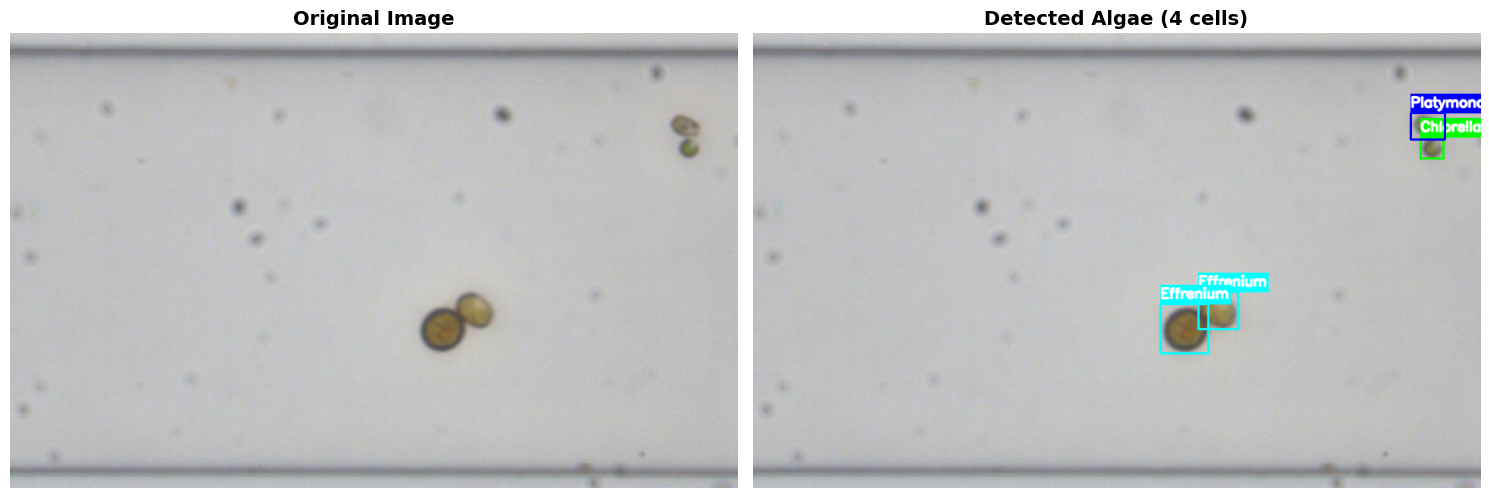

In [19]:
# Display the result
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(1, 2, 1)
original_image = cv2.imread(str(image_path))
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image", fontsize=14, fontweight='bold')
plt.axis('off')

# Annotated image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Algae ({len(bboxes)} cells)", fontsize=14, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

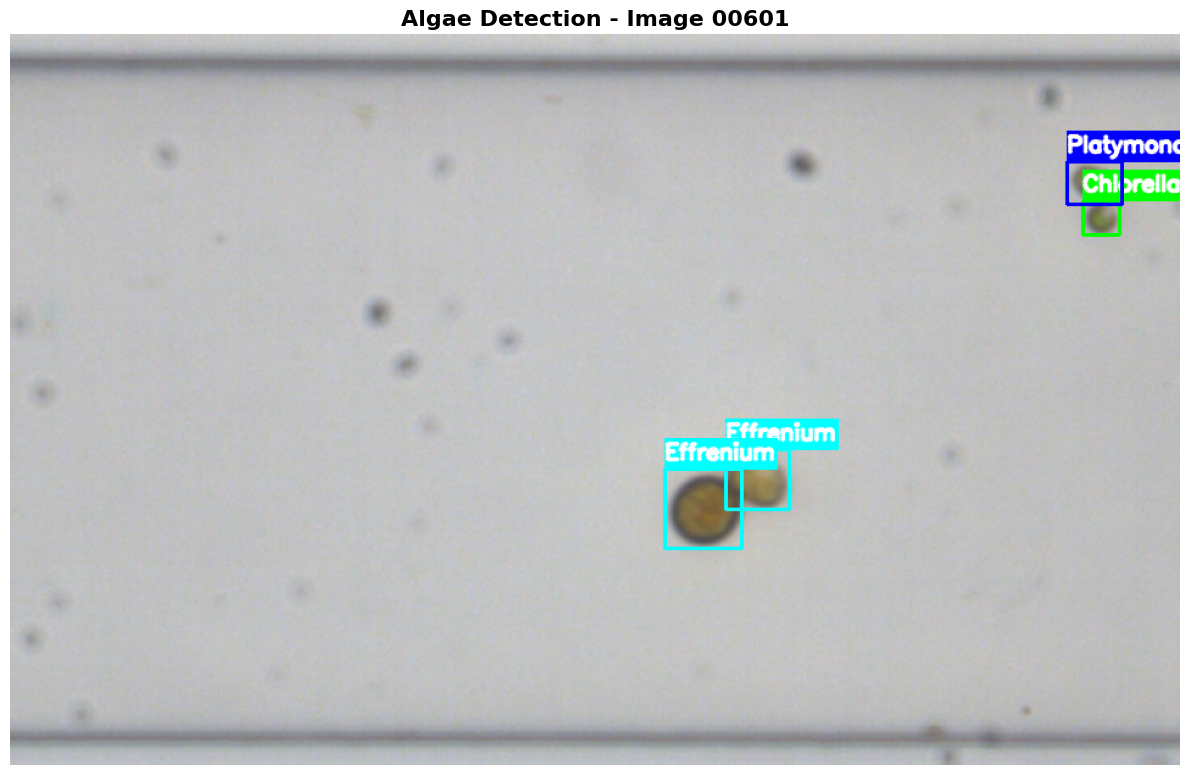


✅ Annotated image saved to: outputs\visualizations\00601_annotated.jpg


In [20]:
# Display only the annotated image in larger size
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title(f"Algae Detection - Image {image_id}", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n✅ Annotated image saved to: {output_path}")

## Visualize Multiple Random Images

Let's visualize a few more random images to see different algae types:

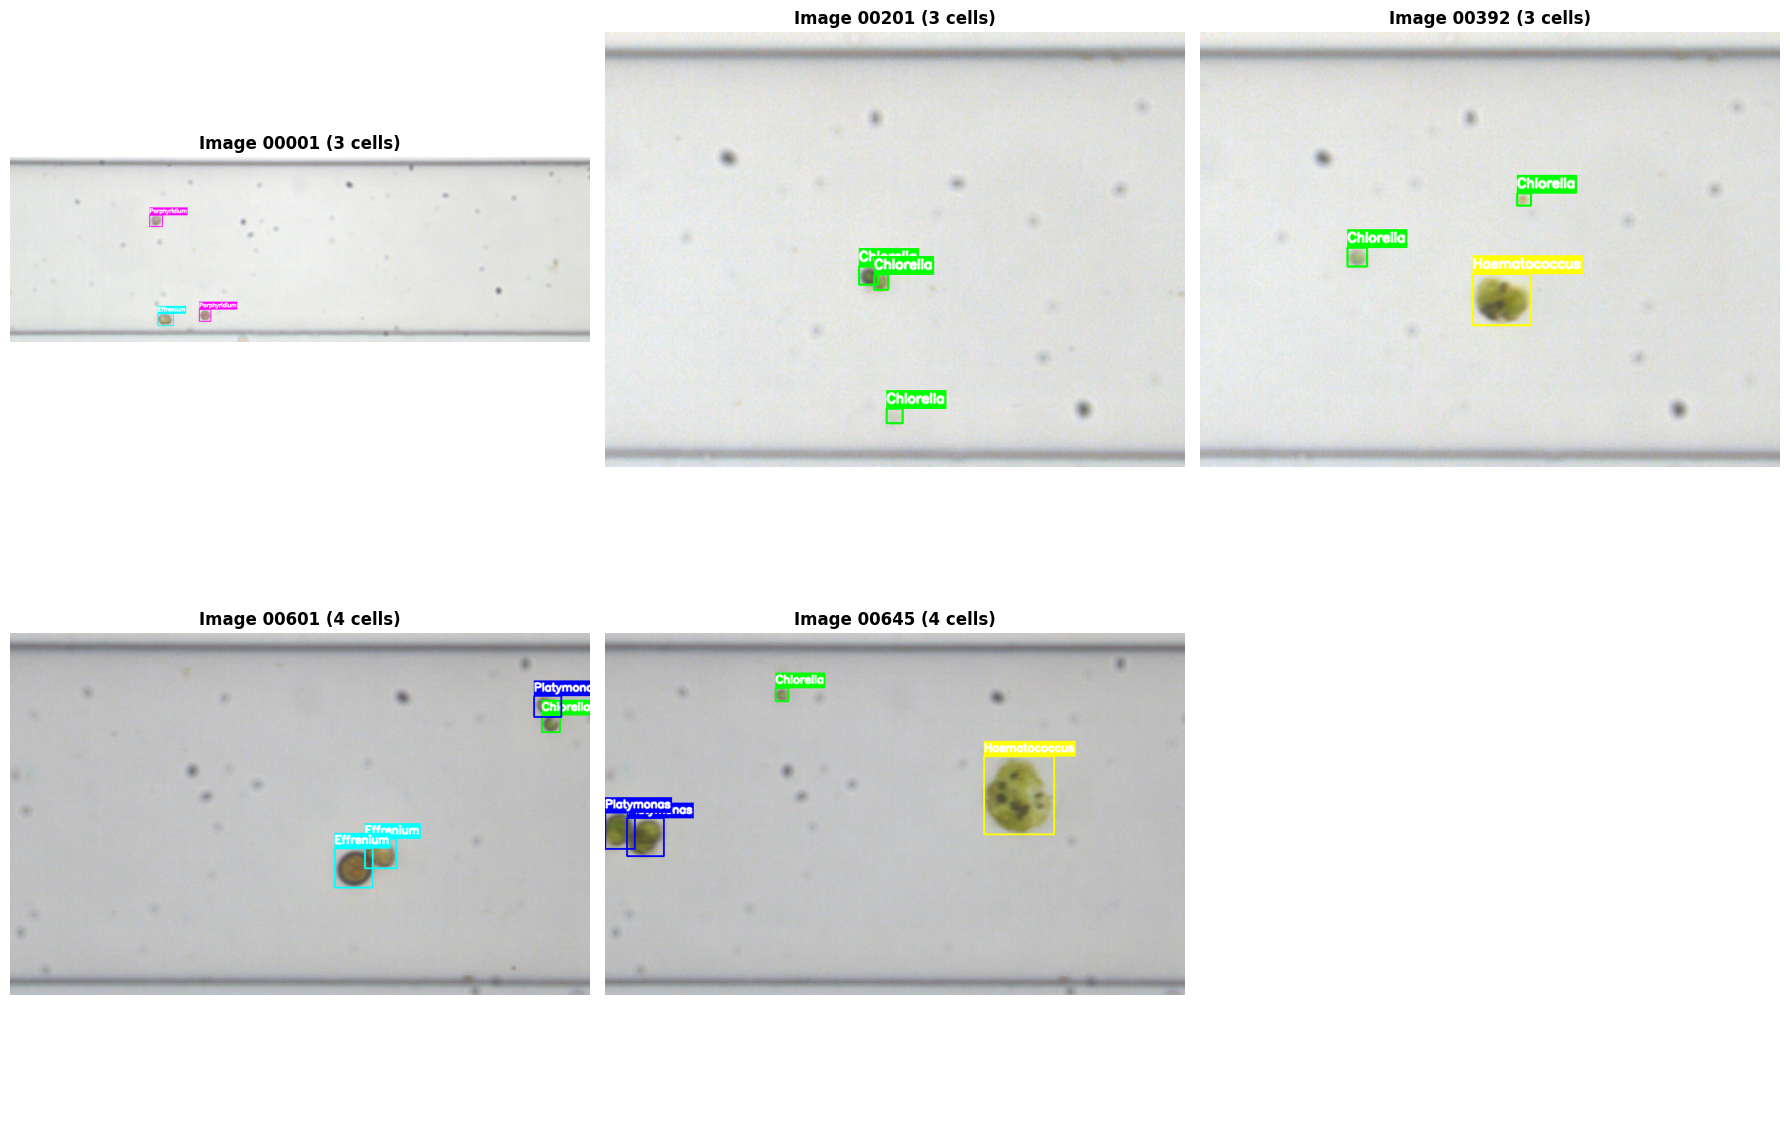

In [21]:
# Select random images
image_ids = ["00001", "00201", "00392", "00601", "00645"]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, image_id in enumerate(image_ids):
    img_path = Path(f"data/train/images/{image_id}.jpg")
    lbl_path = Path(f"data/train/labels/{image_id}.txt")
    
    if img_path.exists() and lbl_path.exists():
        annotated_img, bboxes = visualize_algae_detection(
            img_path, lbl_path, CLASS_NAMES, CLASS_COLORS
        )
        
        axes[idx].imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        axes[idx].set_title(f"Image {image_id} ({len(bboxes)} cells)", fontweight='bold')
        axes[idx].axis('off')

# Hide the last subplot if not used
axes[-1].axis('off')

plt.tight_layout()
plt.show()

## Class Distribution Visualization

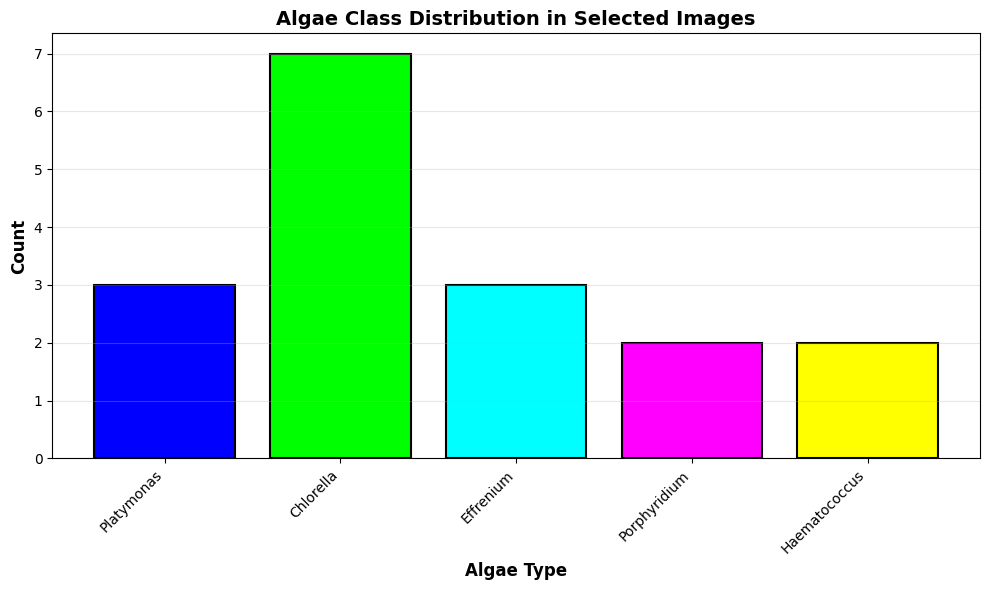

In [22]:
# Count class distribution in the selected images
from collections import Counter

class_counts = Counter()

for image_id in image_ids:
    lbl_path = Path(f"data/train/labels/{image_id}.txt")
    if lbl_path.exists():
        with open(lbl_path, 'r') as f:
            for line in f:
                if line.strip():
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1

# Plot distribution
plt.figure(figsize=(10, 6))
classes = [CLASS_NAMES[i] for i in sorted(class_counts.keys())]
counts = [class_counts[i] for i in sorted(class_counts.keys())]
colors_rgb = [(c[2]/255, c[1]/255, c[0]/255) for c in [CLASS_COLORS[i] for i in sorted(class_counts.keys())]]

plt.bar(classes, counts, color=colors_rgb, edgecolor='black', linewidth=1.5)
plt.xlabel('Algae Type', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Algae Class Distribution in Selected Images', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()